In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm.notebook import tqdm
import os
import gym

import matplotlib.pyplot as plt

In [2]:
#replay buffer for memory replay
class ReplayBuffer():
    
    def __init__(self, input_size, mem_size=10000, batch_size=64):
        self.mem_size = mem_size
        self.index = 0
        self.batch_size=batch_size
        
        self.obs_memory = np.empty((self.mem_size, *input_size), dtype=np.float32)
        self.action_memory = np.empty((self.mem_size), dtype=np.int64)
        self.reward_memory = np.empty((self.mem_size), dtype=np.float32)
        self.next_obs_memory = np.empty((self.mem_size, *input_size), dtype=np.float32)
        self.terminal_memory = np.empty((self.mem_size), dtype=np.bool)
        
    def add_memory(self, obs, action, reward, next_obs, done):
        self.obs_memory[self.index] = obs
        self.action_memory[self.index] = action
        self.reward_memory[self.index] = reward
        self.next_obs_memory[self.index] = next_obs
        self.terminal_memory[self.index] = done
        self.index += 1
        self.index %= self.mem_size

    def get_memory_batch(self):
        idxs = np.random.choice(len(self), self.batch_size, replace=False)
        
        obss = self.obs_memory[idxs]
        actions = self.action_memory[idxs]
        rewards = self.reward_memory[idxs]
        next_obss = self.next_obs_memory[idxs]
        dones = self.terminal_memory[idxs]
        
        return obss, actions, rewards, next_obss, dones
    
    def __len__(self):
        return min(self.index, self.mem_size)

In [61]:
#function approximator of the Q-Function
class QNN(nn.Module):
    
    def __init__(self, input_size, hidden_sizes, action_size, lr, save_dir, name):
        super(QNN, self).__init__()
        self.output_file = os.path.join(save_dir, name)
        self.input_layer = nn.Linear(*input_size, hidden_sizes[0])
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_sizes[i], hidden_sizes[i+1]) 
                                            for i in range(len(hidden_sizes)-1)])
        self.output_layer = nn.Linear(hidden_sizes[-1], action_size)
        
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        self.loss = nn.MSELoss()
        self.optimizer = optim.RMSprop(self.parameters(), lr=lr)
        self.to(self.device)
        
    
    def forward(self, state):
        x = state
        x = F.relu(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = F.relu(hidden_layer(x))
        x = self.output_layer(x)
        return x
        
    
    def save(self):
        torch.save(self.state_dict(), self.output_file)
    
    def load(self):
        self.load_state_dict(torch.load(self.output_file))
        

In [62]:
#Agent
class DQN:
    
    def __init__(self, input_size, hidden_sizes, action_size, min_epsilon, max_epsilon, epsilon_decay, 
                 gamma, lr, mem_size, batch_size, save_dir):
        self.replay_buffer = ReplayBuffer(input_size, mem_size, batch_size)
        self.qnn_target = QNN(input_size, hidden_sizes, action_size, lr, save_dir, name='target.pt')
        self.qnn_online = QNN(input_size, hidden_sizes, action_size, lr, save_dir, name='online.pt')
        
        self.epsilon = max_epsilon
        self.min_epsilon = min_epsilon
        self.epsilon_decay = epsilon_decay
        self.gamma = gamma
        self.action_size = action_size
        self.batch_size = batch_size
    
    def epsilon_greedy(self, obs):
        if np.random.random() > self.epsilon:
            with torch.no_grad():
                obs = torch.from_numpy(obs).to(self.qnn_online.device).float()
                action = np.argmax(self.qnn_online.forward(obs).detach().numpy())

        else:
            action = np.random.choice(self.action_size)
        return action
    
    def decrement_epsilon(self):
        if self.epsilon <= self.min_epsilon:
            return
        
        epsilon = self.epsilon - self.epsilon_decay
        self.epsilon = max(epsilon, self.min_epsilon)
    
    def add_memory(self, obs, action, reward, next_obs, done):
        self.replay_buffer.add_memory(obs, action, reward, next_obs, done)
    
    def get_memory_batch(self):
        obss, actions, rewards, next_obss, dones = self.replay_buffer.get_memory_batch()
        device = self.qnn_online.device
        obss = torch.from_numpy(obss).to(device)
        actions = torch.from_numpy(actions).to(device)
        rewards = torch.from_numpy(rewards).to(device)
        next_obss = torch.from_numpy(next_obss).to(device)
        dones = torch.from_numpy(dones).to(device)
        return obss, actions, rewards, next_obss, dones
        
    def learn(self):
        if len(self.replay_buffer) < self.batch_size:
            return
        
        self.qnn_online.optimizer.zero_grad()
        obss, actions, rewards, next_obss, dones = self.get_memory_batch()
        with torch.no_grad():
            target = rewards + self.gamma * torch.max(self.qnn_target.forward(next_obss).detach(), dim=1)[0] \
                * torch.logical_not(dones)
        target = target.unsqueeze(1)
        online = self.qnn_online.forward(obss).gather(dim=1, index=actions.unsqueeze(1))

        loss = self.qnn_online.loss(online, target)
        loss.backward()
        self.qnn_online.optimizer.step()
        self.decrement_epsilon()
    
    def save(self):
        self.qnn_online.save()
    
    def load(self):
        self.qnn_online.load()
        
    def replace_target_network(self):
        self.qnn_target.load_state_dict(self.qnn_online.state_dict())
    

In [63]:
# Configuration
ENV = gym.make('CartPole-v1')
INPUT_SIZE = ENV.observation_space.shape
HIDDEN_SIZES = (512, 128)
ACTION_SIZE = ENV.action_space.n
EPISODES = 1000
MIN_EPSILON=0.3
MAX_EPSILON=1
EPSILON_DECAY=0.00025
GAMMA = 0.99
LEARNING_RATE = 0.0005
MEMORY_SIZE = 50000
BATCH_SIZE = 64
SAVE_DIR = './progress'

In [64]:
#Main loop
agent = DQN(INPUT_SIZE, HIDDEN_SIZES, ACTION_SIZE, 
            min_epsilon=MIN_EPSILON, max_epsilon=MAX_EPSILON, epsilon_decay=EPSILON_DECAY,
            gamma=GAMMA, lr=LEARNING_RATE, 
            mem_size=MEMORY_SIZE, batch_size=BATCH_SIZE, save_dir=SAVE_DIR)

reward_tracking = []
best_mean = 0
for episode in tqdm(range(EPISODES)):
    obs, done = ENV.reset(), False
    reward_sum = 0
    while not done:
        
        action = agent.epsilon_greedy(obs)
        next_obs, reward, done, info = ENV.step(action)
        is_truncated = 'TimeLimit.truncated' in info and info['TimeLimit.truncated']
        terminal = done and (not is_truncated)
        reward_sum += reward
        agent.add_memory(obs, action, reward, next_obs, terminal)
        obs = next_obs
        agent.learn()
    reward_tracking.append(reward_sum)
    
    # OUTPUT INFO
    if (episode > 100):
        reward_mean = np.array(reward_tracking[-100:]).mean()
        if reward_mean > best_mean:
            best_mean = reward_mean
            print(f'--NEW BEST MEAN: {best_mean}')
            print('--- Saving Agent ---')
            agent.save()
        if reward_mean > 475:
            print('---GOAL REACHED---')
            print('---SAVING AGENT---')
            agent.save()
            break
    
    if (episode + 1) % 100 == 0:
        print(f'Episode: {episode+1}, epsilon: {agent.epsilon}')
        reward_mean = np.array(reward_tracking[-100:]).mean()
        print(f'Mean of last 100 sums of rewards is: {reward_mean}')

        
    if (episode + 1) % 10 == 0:
        print('--- Replacing target network ---')
        agent.replace_target_network()
        

--- Replacing target network ---
--- Replacing target network ---
--- Replacing target network ---
--- Replacing target network ---
--- Replacing target network ---
--- Replacing target network ---
--- Replacing target network ---
--- Replacing target network ---
--- Replacing target network ---
Episode: 100, epsilon: 0.3
Mean of last 100 sums of rewards is: 62.95
--- Replacing target network ---
--NEW BEST MEAN: 65.42
--- Saving Agent ---
--NEW BEST MEAN: 67.0
--- Saving Agent ---
--NEW BEST MEAN: 68.35
--- Saving Agent ---
--NEW BEST MEAN: 69.55
--- Saving Agent ---
--NEW BEST MEAN: 70.95
--- Saving Agent ---
--NEW BEST MEAN: 71.69
--- Saving Agent ---
--NEW BEST MEAN: 72.7
--- Saving Agent ---
--NEW BEST MEAN: 72.87
--- Saving Agent ---
--NEW BEST MEAN: 74.63
--- Saving Agent ---
--- Replacing target network ---
--NEW BEST MEAN: 75.34
--- Saving Agent ---
--NEW BEST MEAN: 75.96
--- Saving Agent ---
--NEW BEST MEAN: 77.56
--- Saving Agent ---
--NEW BEST MEAN: 78.74
--- Saving Agent -

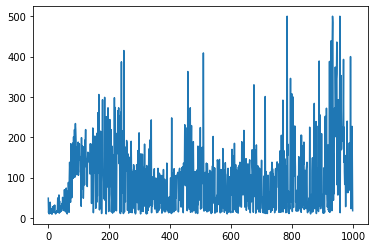

In [65]:
plt.plot(reward_tracking)
plt.show()